In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
import sys
sys.path.append('..')

import logging
from src.utils import setup_logging
setup_logging(console=True, file=True, debug=True, file_basename="k_sweep_BIG")
logger = logging.getLogger(__name__)

import pandas as pd
from data.tempdata import TempData
import matplotlib.pyplot as plt

from src.plot import plot_predictive
from src.informed_np import InformedNeuralProcess
from tqdm import tqdm
# from src.loss import ELBOLoss
from src.loss import ELBOLoss
from src.train import train  
from src.plot import plot_predictive

[INFO]: Logging setup completed at 15-08-2024-094611        (utils.py:62 [09:46:11])
/workspace/miniconda3/envs/pt2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
logging.info(f'Using DEVICE: {DEVICE}')

x_dim = 1
y_dim = 1
determ_dim = 128  # Dimension of representation of context points
latent_dim = 128  # Dimension of sampled latent variable
hidden_dim = 128  # Dimension of hidden layers in encoder and decoder

USE_KNOWLEDGE = True

args = dict(
            x_dim=x_dim,
            y_dim=y_dim,
            hidden_dim=hidden_dim,
            latent_dim=latent_dim,
            determ_dim=determ_dim,
            knowledge_dim=128,
            mlps_activation=nn.GELU(),
            x_proj_dim=1,
            n_h_layers_x_proj=0,
            n_h_layers_decoder=4,
            n_h_layers_latent_xy_encoder=3,
            n_h_layers_film_latent_encoder=3,
            path='latent',
            train_num_z_samples=4,
            test_num_z_samples=32,
            use_bias=True,
            use_context_in_target=True, # TODO investigate
            use_latent_self_attn=True,
            # use_determ_self_attn=True,
            # use_determ_cross_attn=True,
            use_knowledge=USE_KNOWLEDGE,
            knowledge_dropout=0.4,
            roberta_return_cls=True,
            tune_llm_layer_norms=True,
            freeze_llm=True,
            knowledge_projection_n_h_layers=0,
            knowledge_aggregation_method='FiLM+MLP',
            device='cuda',
            beta=1.0
        )
# assert "use_knowledge" not in args
# assert "knowledge_dropout" not in args

data_path = '../data/data_with_desc.csv'
data_df = pd.read_csv(data_path, header=None)


AVG_LOSS_PRINT_INTERVAL = 250
PLOT_SAMPLE_INTERVAL = 1000
MAX_ITERS = 10000

LEARNING_RATE = 1e-3
loss_function = ELBOLoss(beta=1, reduction='mean')
random_states = [85, 98, 87]

MAX_NUM_CONTEXT = 10



[INFO]: Using DEVICE: cuda:0        (2661872398.py:2 [09:46:26])


In [3]:
data = TempData(data=data_df , max_num_context=MAX_NUM_CONTEXT, device=DEVICE, random_state=85)

inp_model = InformedNeuralProcess(
        **args
).to(DEVICE)

inp_model.load_state_dict(torch.load('../exp/sweep/inp-kdropsweep-0.4-rs-85_iter4000.pt'))

[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [09:46:29])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [09:46:29])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [09:46:29])
[DEBUG]: Starting new HTTPS connection (1): huggingface.co:443        (connectionpool.py:1019 [09:46:29])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/1.1" 200 0        (connectionpool.py:474 [09:46:29])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/1.1" 200 0        (connectionpool.py:474 [09:46:29])
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[DEBUG]: Freezing LLM parameters        (knowledge_encoder.py:30 [09:46:29])

<All keys matched successfully>

In [4]:
batch_size = 1
batch = data.generate_batch(batch_size=batch_size,
                                        device=DEVICE,
                                        return_knowledge=USE_KNOWLEDGE,
                                        split='test')

print(batch.knowledge)

['The night will start off cool with temperatures gradually dropping to 7.3°C by early morning, then warming up to a comfortable 15.9°C in the afternoon. As evening approaches, expect a slight chill with temperatures dipping back down to around 12.3°C by midnight.']


NLL: 428.6498718261719
NLL: 2266.731201171875


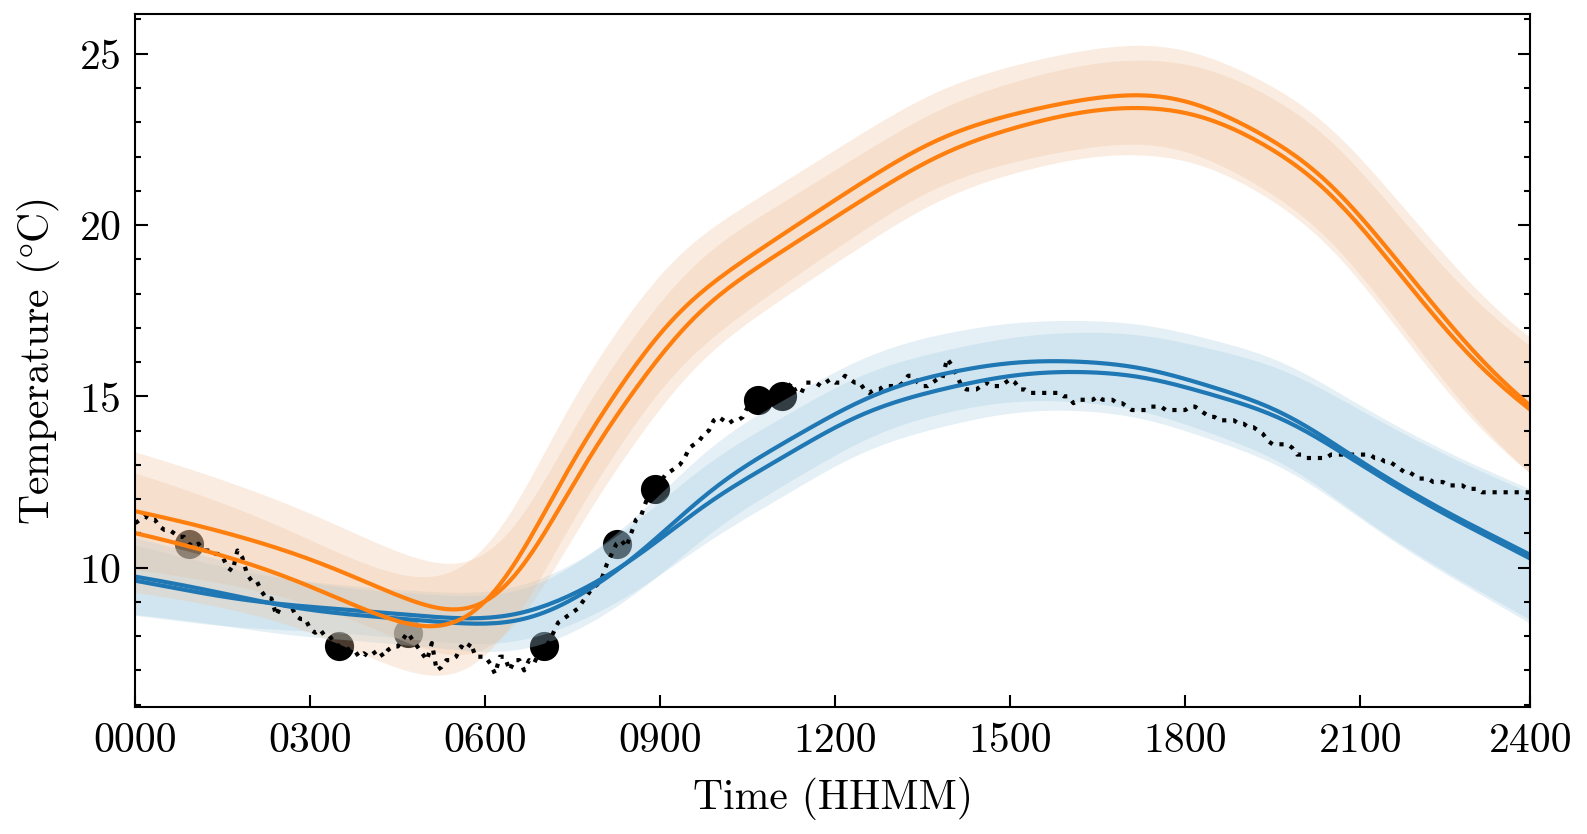

In [31]:
plt.style.use('../figures/mplstyles/thesis.mplstyle')
num_trajectories = 2

changed_knowledge = ['The night will start off cool with temperatures gradually dropping to 17.3°C by early morning, then warming up to a comfortable 25.9°C in the afternoon. As evening approaches, expect a slight chill with temperatures dipping back down to around 22.3°C by midnight.']



inp_model.training = False
with torch.no_grad():
    # make device be the device of the model
    p_y_pred_t, q_z_context_t, q_z_target_t = inp_model(batch.x_context,
                                              batch.y_context,
                                              batch.x_target,
                                              batch.y_target,
                                              batch.knowledge)

    print(f"NLL: {loss_function(p_y_pred_t, q_z_context_t, None, batch.y_target)['loss'].item()}")
    
    mu = p_y_pred_t.mean.cpu()  # Shape [num_z_samples, batch_size, num_target_points, y_dim=1]
    sigma = p_y_pred_t.stddev.cpu()

    p_y_pred_c, q_z_context_c, q_z_target_c = inp_model(batch.x_context,
                                                  batch.y_context,
                                                  batch.x_target,
                                                  batch.y_target,
                                                  changed_knowledge)

    print(f"NLL: {loss_function(p_y_pred_c, q_z_context_c, None, batch.y_target)['loss'].item()}")
    
    mu_c = p_y_pred_c.mean.cpu()  # Shape [num_z_samples, batch_size, num_target_points, y_dim=1]
    sigma_c = p_y_pred_c.stddev.cpu()


LINE_COLOURS = ['#1f77b4', '#ff7f0e', '#2ca02c',]
FILL_COLOURS = ['#A6CEE3', '#f0c39c', '#b8deb8']


batch_size, _, _ = batch.x_context.shape
assert batch_size <= 3, 'Batch size should be <= 3 for plot clarity'


x_context, y_context = batch.x_context.cpu(), batch.y_context.cpu()
x_target, y_target = batch.x_target.cpu(), batch.y_target.cpu()

plt.figure(figsize=(6, 3))

plt.plot(x_target.flatten(), y_target.flatten(), 'k:', label=None)  # Plot ground truth GP
plt.scatter(x_context.flatten(), y_context.flatten(), c='k', label=None)  # Plot context points 

num_z_samples = mu.shape[0]
assert num_trajectories <= num_z_samples, "num_trajectories must be less than num_z_samples"
z_sample_idx = np.random.choice(num_z_samples, size=num_trajectories)
for j in z_sample_idx:
    plt.plot(x_target.flatten(), mu[j].flatten(), color=LINE_COLOURS[0], label="Original knowledge")
    plt.fill_between(
        x_target.flatten(),
        mu[j].flatten() - sigma[j].flatten(),
        mu[j].flatten() + sigma[j].flatten(),
        alpha=0.3,
        facecolor=FILL_COLOURS[0],
        interpolate=True, label=None)

    plt.plot(x_target.flatten(), mu_c[j].flatten(), color=LINE_COLOURS[1], label="Changed knowledge")
    plt.fill_between(
        x_target.flatten(),
        mu_c[j].flatten() - sigma_c[j].flatten(),
        mu_c[j].flatten() + sigma_c[j].flatten(),
        alpha=0.3,
        facecolor=FILL_COLOURS[1],
        interpolate=True, label=None)

#plt.ylim(-4, 4)

plt.xlim(-2, 2)
# print(list(x_target[0::36])+ [2.0])

# Formatting the x-axis to display time in "HHMM" format
plt.xticks(list(x_target[0].flatten()[::36])+ [2.0], labels=["0000", "0300", "0600", "0900", "1200", "1500", "1800", "2100", "2400"])
# plt.legend([None, None, "Original knowledge", , "Changed knowledge"])
# Label axes
plt.xlabel('Time (HHMM)')
plt.ylabel('Temperature ($\degree$C)')

# plt.savefig(f'{save_name}.png', dpi=300)
plt.show()

[[5.29087769e+02 4.30231934e+01 1.41278076e+01 3.00895996e+01
  2.56273193e+01 7.57562256e+00 3.13842163e+01 2.79822388e+01
  6.58839111e+01 6.90787354e+01 6.21364136e+01 1.35103943e+02
  1.83545776e+02 2.70285767e+02 9.68676147e+01]
 [2.87357605e+02 9.62500000e+01 8.31103516e+00 1.48244629e+01
  2.54552002e+01 1.10522461e+01 2.14407959e+01 7.21191406e+00
  9.04553223e+00 2.52868652e+00 1.16445312e+01 3.46872559e+01
  7.23011475e+01 1.85011841e+02 8.56319580e+01]
 [1.28885645e+03 1.45075391e+03 1.09908411e+03 4.62839355e+01
  1.00128467e+03 1.19651001e+03 7.78492188e+02 1.58298340e+01
  5.02479980e+02 1.25548114e+03 1.39558282e+03 1.32421057e+03
  1.00294788e+03 9.48599609e+02 1.37279956e+03]
 [5.02325562e+02 6.08945862e+02 6.68315674e+02 6.53814087e+02
  4.45992310e+02 4.33513733e+02 4.00176331e+02 1.35966797e+01
  7.90677490e+01 1.53732422e+02 3.42586670e+02 1.44104004e+00
  4.65439758e+02 3.15618042e+02 5.57666992e+02]
 [1.41435529e+03 1.50482288e+03 1.52260217e+03 1.33191736e+03
  

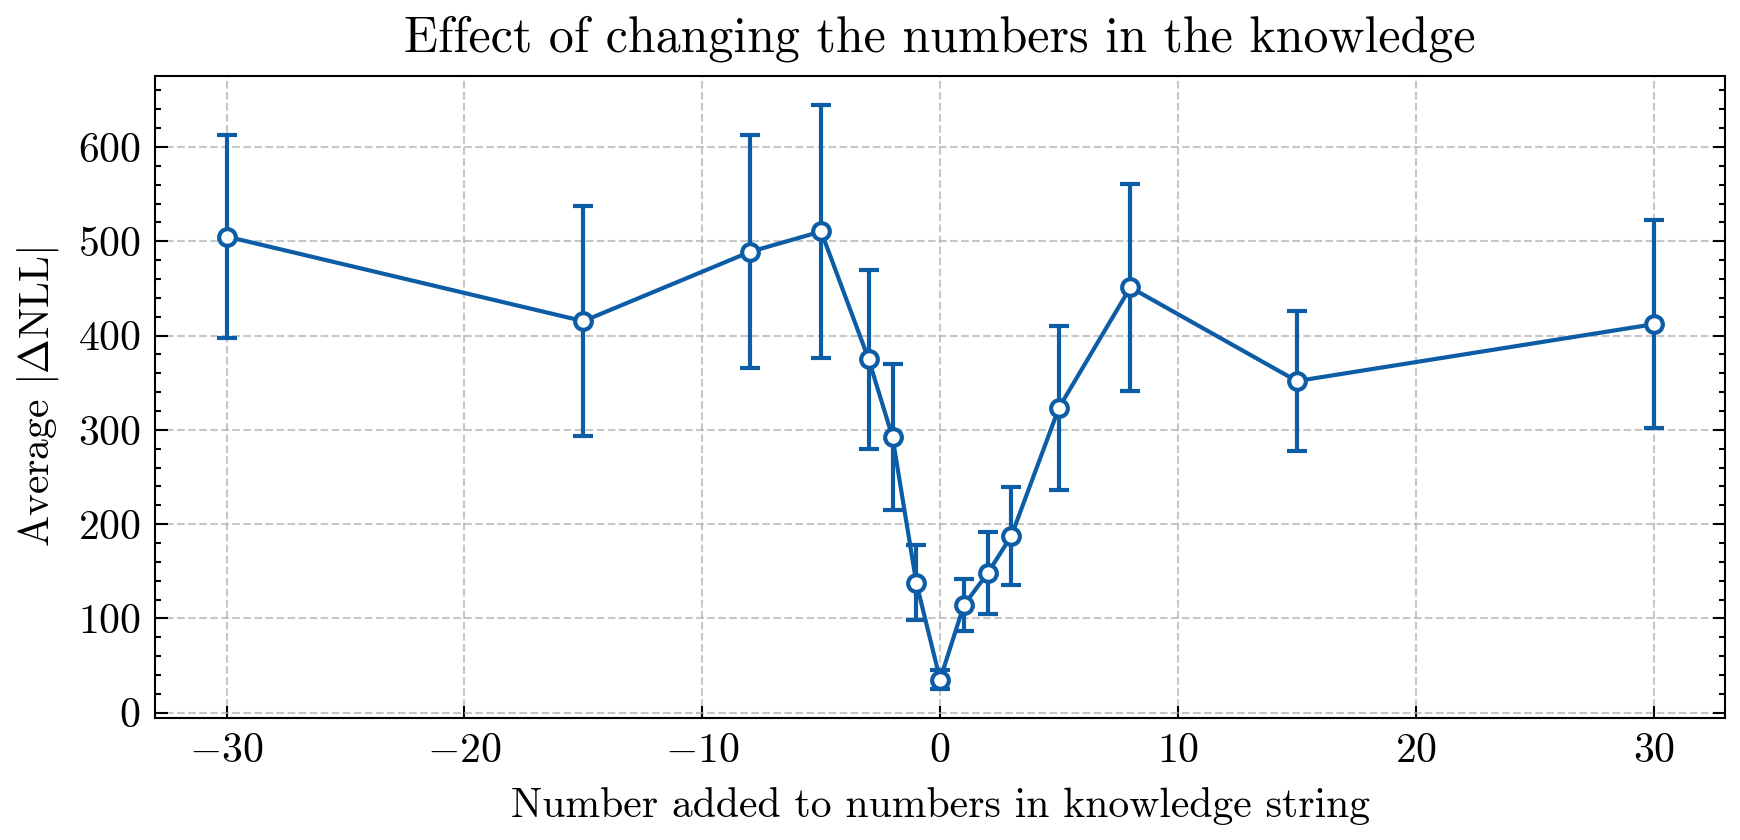

Detailed Results:
n	Mean Change	Standard Error
-30	505.0480		107.4311
-15	415.2698		121.8001
-8	488.7202		123.5005
-5	510.4197		133.8019
-3	374.5942		94.4339
-2	292.2418		77.4508
-1	137.8326		39.5790
0	35.0580		10.1268
1	114.1397		27.8464
2	147.8194		43.5972
3	187.6808		52.0521
5	323.5476		86.9706
8	451.0675		109.5091
15	351.7324		74.2093
30	412.0261		110.3630


In [19]:
from scipy import stats

plt.style.use('../figures/mplstyles/thesis.mplstyle')
num_trajectories = 2
inp_model.training = False

def calculate_nll(knowledge):
    with torch.no_grad():
        p_y_pred, q_z_context, q_z_target = inp_model(batch.x_context,
                                                      batch.y_context,
                                                      batch.x_target,
                                                      batch.y_target,
                                                      [knowledge])
        nll = loss_function(p_y_pred, q_z_context, None, batch.y_target)['loss'].item()
    return nll

# Calculate NLL for unperturbed knowledge
unperturbed_nlls = [calculate_nll(k) for k in batch.knowledge]

# Calculate NLL changes for perturbed knowledge
nll_changes = []
for original, perturbed_list, unperturbed_nll in zip(batch.knowledge, perturbed_results, unperturbed_nlls):
    changes = []
    for perturbed in perturbed_list:
        nll = calculate_nll(perturbed)
        change = abs(nll - unperturbed_nll)
        changes.append(change)
    nll_changes.append(changes)

# Convert to numpy array for easier manipulation
nll_changes = np.array(nll_changes)

print(nll_changes)

# Calculate mean and standard error of NLL changes
mean_changes = np.mean(nll_changes, axis=0)
se_changes = stats.sem(nll_changes, axis=0)

# Plot
plt.figure(figsize=(6, 3))
plt.errorbar(n_values, mean_changes, yerr=se_changes, fmt='-o', capsize=2.5, markersize=4,  mfc='white')
plt.xlabel('Number added to numbers in knowledge string')
plt.ylabel(r'Average $|\Delta\text{NLL}|$')
plt.title('Effect of changing the numbers in the knowledge')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('../figures/number_robustness_graph.png', dpi=600)
plt.show()

# Print detailed results
print("Detailed Results:")
print("n\tMean Change\tStandard Error")
for n, mean, se in zip(n_values, mean_changes, se_changes):
    print(f"{n}\t{mean:.4f}\t\t{se:.4f}")

In [ ]:
['The night will be bitterly cold with temperatures hovering around -14 degrees, slightly warming up to -11 degrees in the afternoon. Expect a chilly evening as temperatures continue to remain below freezing.']